In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import collections
from bs4 import BeautifulSoup

## **Unindo os datasets**

In [4]:
bechdel_df = pd.read_csv('datasets/Bechdel_detailed.csv')
links_df = pd.read_csv('datasets/movie-dataset/links.csv') # contém o id do imdb e tmdb de cada filme

# remove colunas não usadas
bechdel_df = bechdel_df.drop(['Unnamed: 0', 'submitterid', 'date', 'visible', 'id'], axis=1)

# renomeia rating para não coincidir com o dos outros datasets
bechdel_df = bechdel_df.rename(columns={'rating': 'bt_score'})

# junta os 3 dataframes e descarta colunas duplicadas
bechdel_df = pd.merge(bechdel_df, links_df, left_on='imdbid', right_on='imdbId', how='inner').drop(['imdbId', 'movieId'], axis=1)

bechdel_df.head()

,title,year,bt_score,dubious,imdbid,tmdbId
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,315946.0
1,Sallie Gardner at a Gallop,1878.0,0.0,0.0,2221420.0,194079.0
2,Buffalo Running,1883.0,0.0,0.0,5459794.0,426903.0
3,Man Walking Around the Corner,1887.0,0.0,0.0,2075247.0,159897.0
4,Accordion Player,1888.0,0.0,0.0,1758563.0,96882.0


In [5]:
bechdel_df = bechdel_df.sort_values(by=['bt_score', 'year'], ascending=[False, True]).reset_index(drop=True)
bechdel_df.head()

,title,year,bt_score,dubious,imdbid,tmdbId
0,Cinderella,1899.0,3.0,0.0,230.0,114108.0
1,Gretchen the Greenhorn,1916.0,3.0,0.0,6745.0,126925.0
2,Snow White,1916.0,3.0,0.0,7361.0,174598.0
3,"Poor Little Rich Girl, The",1917.0,3.0,0.0,8443.0,95866.0
4,Stella Maris,1918.0,3.0,0.0,9652.0,70753.0


## **Tratamento dos dados**

### **Retirada de nulos**

In [6]:
bechdel_df.describe()

,year,bt_score,dubious,imdbid,tmdbId
count,7635.000000,7635.000000,7337.000000,7.635000e+03,7635.000000
mean,1994.283824,2.102161,0.090364,8.939595e+05,69241.580092
std,23.481479,1.100308,0.286722,1.160944e+06,100273.948321
min,1874.000000,0.000000,0.000000,1.000000e+00,5.000000
25%,1986.000000,1.000000,0.000000,9.210250e+04,9682.500000
50%,2003.000000,3.000000,0.000000,3.272470e+05,23567.000000
75%,2011.000000,3.000000,0.000000,1.426131e+06,75791.000000
max,2020.000000,3.000000,1.000000,6.536944e+06,461615.000000


In [7]:
data = bechdel_df.dropna().copy()

In [8]:
data.describe()

,year,bt_score,dubious,imdbid,tmdbId
count,7337.000000,7337.000000,7337.000000,7.337000e+03,7337.000000
mean,1994.117759,2.100995,0.090364,9.157402e+05,71682.679297
std,23.800150,1.102451,0.286722,1.177499e+06,101516.902007
min,1874.000000,0.000000,0.000000,1.000000e+00,5.000000
25%,1985.000000,1.000000,0.000000,9.109300e+04,9960.000000
50%,2003.000000,3.000000,0.000000,3.337800e+05,25643.000000
75%,2011.000000,3.000000,0.000000,1.470023e+06,79070.000000
max,2020.000000,3.000000,1.000000,6.536944e+06,461615.000000


### **Transformando tipos de dados**

In [9]:
data['year'] = data['year'].astype('int')
data['bt_score'] = data['bt_score'].astype('int')
data['dubious'] = data['dubious'].astype('int')
data['imdbid'] = data['imdbid'].astype('int')
data['tmdbId'] = data['tmdbId'].astype('int')

### **API**

##### **Raspar dados dos filmes**

In [10]:
data['genres'] = pd.NA
data['popularity'] = pd.NA
data['production_companies'] = pd.NA
data['production_countries'] = pd.NA
data['release_date'] = pd.NA
data['revenue'] = pd.NA
data['title'] = pd.NA
data['vote_average'] = pd.NA
data['vote_count'] = pd.NA
data['cast'] = pd.NA
data['crew'] = pd.NA

In [11]:
# api_key = 'b12a91c6b0aa37015f0b966b61efd74d'

# for index, row in data.iterrows():
#     try:
#         info = requests.get(f'https://api.themoviedb.org/3/movie/{row["tmdbId"]}?api_key={api_key}')
#         credits = requests.get(f'https://api.themoviedb.org/3/movie/{row["tmdbId"]}/credits?api_key={api_key}')
        
#         details = info.json()
#         details['cast'] = credits.json()['cast']
#         details['crew'] = credits.json()['crew']

#         data.loc[index, 'budget'] = details['budget']
#         data.loc[index, 'genres'] = str(details['genres'])
#         data.loc[index, 'popularity'] = details['popularity']
#         data.loc[index, 'production_companies'] = str(details['production_companies'])
#         data.loc[index, 'production_countries'] = str(details['production_countries'])
#         data.loc[index, 'release_date'] = details['release_date']
#         data.loc[index, 'revenue'] = details['revenue']
#         data.loc[index, 'title'] = details['title']
#         data.loc[index, 'vote_average'] = details['vote_average']
#         data.loc[index, 'vote_count'] = details['vote_count']
#         data.loc[index, 'cast'] = str(details['cast'])
#         data.loc[index, 'crew'] = str(details['crew'])
#     except:
#         print(row['tmdbId'])

# data.to_csv('api_data.csv')

In [12]:
data = pd.read_csv('api_data.csv', index_col=0)
data

,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,release_date,revenue,vote_average,vote_count,cast,crew,budget
0,Cinderella,1899,3,0,230,114108,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",3.762,"[{'id': 7159, 'logo_path': None, 'name': 'Star...","[{'iso_3166_1': 'FR', 'name': 'France'}]",1899-10-01,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0
1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],1916-09-03,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0
2,Snow White,1916,3,0,7361,174598,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",0.817,[],[],1916-12-24,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0
3,The Poor Little Rich Girl,1917,3,0,8443,95866,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.023,"[{'id': 13400, 'logo_path': None, 'name': 'Art...","[{'iso_3166_1': 'US', 'name': 'United States o...",1917-03-05,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0
4,Stella Maris,1918,3,0,9652,70753,"[{'id': 18, 'name': 'Drama'}]",1.310,"[{'id': 21540, 'logo_path': None, 'name': 'Mar...","[{'iso_3166_1': 'US', 'name': 'United States o...",1918-01-21,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,Sand Castle,2017,0,0,2582576,390054,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",31.004,"[{'id': 1557, 'logo_path': '/ccz9bqCu3jSFKbPFn...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2017-04-21,0.0,6.5,631.0,"[{'adult': False, 'gender': 2, 'id': 130253, '...","[{'adult': False, 'gender': 1, 'id': 5914, 'kn...",0.0
7631,Diary of a Wimpy Kid: The Long Haul,2017,0,0,6003368,417830,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",17.122,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",2017-05-19,40120144.0,5.3,355.0,"[{'adult': False, 'gender': 2, 'id': 1517834, ...","[{'adult': False, 'gender': 2, 'id': 1999, 'kn...",22000000.0
7632,God's Own Country,2017,0,0,5635086,428493,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",16.294,"[{'id': 7281, 'logo_path': '/lkqIuaKTm2sg3umwT...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2017-09-01,2559939.0,7.8,715.0,"[{'adult': False, 'gender': 2, 'id': 1206334, ...","[{'adult': False, 'gender': 1, 'id': 2635, 'kn...",0.0
7633,MFKZ,2017,0,0,4717402,461615,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",7.712,"[{'id': 21660, 'logo_path': '/mog3VrjYLXvWDocE...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2018-05-23,461724.0,7.1,222.0,"[{'adult': False, 'gender': 2, 'id': 1265647, ...","[{'adult': False, 'gender': 1, 'id': 90162, 'k...",0.0


#### **Tratamento das colunas**

In [13]:
data.columns

Index(['title', 'year', 'bt_score', 'dubious', 'imdbid', 'tmdbId'], dtype='object')

In [ ]:
data['year'] = data['year'].astype('int')

In [ ]:
data['bt_score'] = data['bt_score'].astype('int')

In [ ]:
data['dubious'] = data['dubious'].astype('int')

In [ ]:
data['cast_gender'] = pd.NA


for index, movie in data.iterrows():
    cast = eval(movie['cast'])
    gender_list = []

    for cast_member in cast:
        gender = cast_member['gender']
        gender_list.append(gender)

    data.loc[index, 'cast_gender'] = str(gender_list)

In [ ]:
data['crew_gender'] = pd.NA


for index, movie in data.iterrows():
    crew = eval(movie['crew'])
    gender_list = []

    for crew_member in crew:
        gender = crew_member['gender']
        gender_list.append(gender)

    data.loc[index, 'crew_gender'] = str(gender_list)

In [ ]:
data['budget'] = data['budget'].astype('int')

In [ ]:
data['genres']

In [ ]:
fig, axs = plt.subplots(figsize=(10, 8), constrained_layout=True)


def plot(axs, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=axs)
    graph.set_title(title, pad=10)


plot(axs, bechdel_df.drop(['imdbid', 'tmdbId', 'imdb_id'], axis=1), 'Mapa de correlação entre variáveis')
plt.show()

## **Gráficos simples**

### **Filmes por nota no Teste de Bechdel**
**Métodos utilizados**
- `collections.Counter()`: conta os valores totais das notas de 0 a 3.
- `DataFrame.from_dict(data, orient='index')`: transforma um dicionário em DataFrame. `orient='index'` faz com que as keys do dicionário sejam usadas como index.

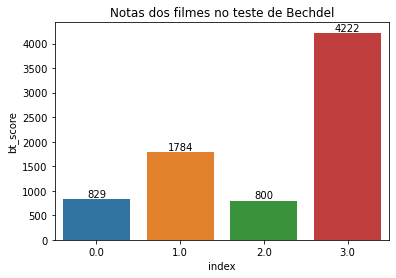

In [13]:
# TOTAL DE FILMES POR NOTA
# score_plot = sns.barplot(x='score', y='total', data=score_df)
score_plot = sns.barplot(x='index', y='bt_score', data=bechdel_df.bt_score.value_counts().reset_index())
score_plot.bar_label(score_plot.containers[0])
score_plot.set(title='Notas dos filmes no teste de Bechdel')
plt.show()

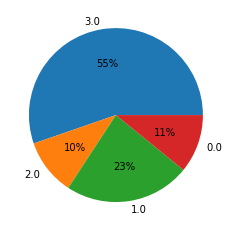

In [14]:
# PORCENTAGEM DOS FILMES
# score_df = df com a quantidade de filmes por nota.
score_df = collections.Counter(bechdel_df.bt_score)
score_df = pd.DataFrame.from_dict(score_df, orient='index').reset_index()
score_df = score_df.rename(columns={'index': 'score', 0: 'total'})
plt.pie(score_df.total, labels = score_df.score.to_list(), autopct='%.0f%%')
score_df.score.to_list()
plt.show()

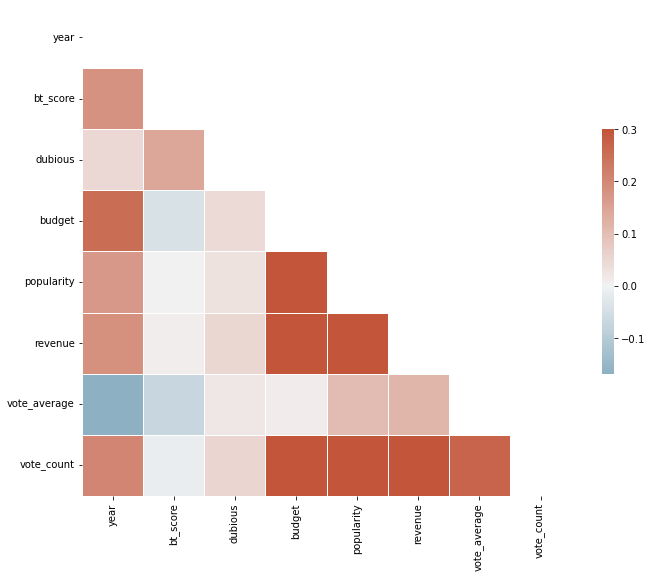

In [18]:
# GRÁFICO DE CORRELAÇÃO
# num_df = df com todas as colunas de valores numéricos. Exceto os ids.
num_df = data[['year', 'bt_score', 'dubious', 'budget', 'popularity', 'revenue', 'vote_average', 'vote_count']]
corr = num_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()